<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

## Tutorial \#3: Brains

</div>

In [ ]:
import sys
sys.path.insert(1, './..')

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

<b><i>Spark</i></b> defines a very special module called <b>spark.nn.Brain</b>, this module has the sole purpose of constructing and running complex models. Moreover, this is where some of the optimizations that allow <b><i>Spark</i></b>'s models to run extremely fast happens.


It all starts with the observation that Spiking Neural Networks are dynamical models and, a few ideas down the line, we may think of computation as flows of information. Critically, flows are not immediate, this allows us to queue every single module contained in <b>Brain</b> for parallel update at the expense of a slightly larger memory footprint and a small latency; most neural models already incorporate delays anyway, what is another one extra timestep more!. 


Although, we expect most of the models being built through the Graph Editor utility. It may be worth to it to explain at least once how construct a <b>Brain</b> through code. As any other <b>Module</b>, <b>Brain</b> also expect a configuration class, which has three key components.

1. Module maps, which contains a description of the modules. <br><br>
2. Input maps, which contains a description of how to map brain inputs to modules. <br><br>
3. Output maps, which contains a description of how to module outputs to brain outputs. <br><br>

Let's start with a simple <b>Brain</b> that can interact with a Gym virtual environment called "CartPole", which is a classic scenario in the RL community.

The first thing we need is a way to transform the continuous signals from the virtual environment to a spiking signal. We can use <b>spark.nn.interfaces.TopologicalLinearSpiker</b> which is a simple mapper that can be used to preserve some simple topological properties of the input data. Instead of instantiating the module directly, we need to create a specification of this module for the brain. This is constructed through <b>spark.ModuleSpecs</b>. This object expects a few inputs: a name for the module, the module we want to create, its associated configuration class and an input map.
</div>

In [4]:
# Imports
import spark
import jax.numpy as jnp

# Define spiker specs.
spiker_specs = spark.ModuleSpecs(
	name ='spiker',													# <--- Defining a module named 'spikes'
    module_cls = spark.nn.interfaces.TopologicalLinearSpiker, 		# <--- The module is of type TopologicalLinearSpiker
	config = spark.nn.interfaces.TopologicalLinearSpikerConfig(     # <--- Configuration of TopologicalLinearSpiker, we politely as the 
		glue = jnp.array(0), 										#      reader to accept this set of parameters as an absolute true.
		mins = jnp.array(-1),  
		maxs = jnp.array(1), 
		resolution = 128, 
		max_freq = 200.0, 
		tau = 30.0,
	),
	inputs = {														# <--- We need to specify all the inputs of the module
		'signal': [													# <--- TopologicalLinearSpiker has a single input named 'signal'
			spark.PortMap(origin='__call__', port='drive'),			# <--- Mappings are defined through PortMap's, which are simply a pair
		]															#      of labels, origin or name of the module producing the input and 
	},																#      port which is the name of the output variable produced by the input
)																	#      module

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

Let's also create a simple pool of recurrent ALIF neurons and another interface that will help use transform the spikes into two continuous variables that we can use to stir the Cart.

</div>

In [ ]:
# ALIF neurons pool.
neurons_pool_specs = spark.ModuleSpecs(
	name ='neurons_pool', 
	module_cls = spark.nn.neurons.ALIFNeuron, 
	inputs = {
		'in_spikes': [
			spark.PortMap(origin='spiker', port='spikes'),				# <--- neurons_pool attends to the output of the spiker
            spark.PortMap(origin='neurons_pool', port='out_spikes'),	# <--- and to itself...
		]
	},
	config = spark.nn.neurons.ALIFNeuronConfig(
        _s_units = (256,),
        _s_async_spikes = True,
	)
)

# Integrator.
integrator = spark.ModuleSpecs(
	name ='integrator', 
	module_cls = spark.nn.interfaces.ExponentialIntegrator, 
	inputs = {
		'spikes': [
			spark.PortMap(origin='neurons_pool', port='out_spikes'),
		]
	},
	config = spark.nn.interfaces.ExponentialIntegratorConfig(
		num_outputs = 2,
	)
)

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

To complete the module map we simply need to wrap everything in a dictionary.
</div>

In [32]:
modules_map = {
    'spiker': spiker_specs,
    'neurons_pool': neurons_pool_specs,
	'integrator': integrator,
}

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

We also need to define the input and output maps. This maps tells the <b>Brain</b> what is expected to read and produce. This is quite straighforward although some format is still expected.
</div>

In [33]:
input_map = {
    'drive': spark.InputSpec(					# <--- Brain now expects a variable named 'drive'
        payload_type=spark.FloatArray,			# <--- with payload_type spark.FloatArray
        shape=(4,), 							# <--- with shape (4,)
        dtype=jnp.float16,						# <--- with dtype float16
        is_optional=False,						# <--- Brain does not allow for optional variables at this moment.
	)
}

output_map = {
    'integrator': {								# <--- Brain now is going to produce an output from the module named 'integrator'
        'signal': spark.OutputSpec(				# <--- Using the output variable 'signal' of the 'integrator' module
            payload_type=spark.FloatArray, 		# <--- with payload_type spark.FloatArray
            shape=(2,), 						# <--- with shape (2,)
            dtype=jnp.float16					# <--- with dtype float16
		)
	}
}

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

We are now ready to create a brain and run it!.

Note that depending on the complexity of the model this may take a little bit of time.
</div>

In [34]:
# Initialize the configuration class
brain_config = spark.nn.BrainConfig(input_map=input_map, output_map=output_map, modules_map=modules_map)
# Construct the brain.
brain = spark.nn.Brain(config=brain_config)
# Build the brain.
brain(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))

{'integrator.signal': FloatArray(value=Array([0., 0.], dtype=float16))}

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

Now we only need to setup the environment and a few utility functions. Let's start with the utility functions.
</div>

In [12]:
import jax
import numpy as np

# Utility function to execute brain efficiently.
@jax.jit
def run_model(graph, state, x):
	model = spark.merge(graph, state)
	out = model(drive=x)
	_, state = spark.split((model))
	return out, state

# Utility function to retrieve data from the model.
@jax.jit
def retrieve_spikes(graph, state,):
	model = spark.merge(graph, state)
	spikes = model.get_spikes_from_cache()
	return spikes

# Utility function to preprocess information from the environment.
def process_obs(x):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	x = x / np.array([2.4, 2.5, 0.2095, 3.5])
	x = np.clip(x, a_min=-1, a_max=1)
	return x

# Reward function.
def compute_real_reward(x, x_prev, r_prev, terminated):
	# CartPos, CartSpeed, PoleAngle, PoleAngSpeed 
	if terminated:
		return 0
	r = (x_prev[0]**2 - x[0]**2) + (x_prev[2]**2 - x[2]**2)
	r = np.clip(0.5 * r_prev + 2 * r, a_min=-1, a_max=1)
	return r

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

Now the virtual environment.
</div>

In [13]:
import gymnasium as gym
import ale_py
import numpy as np

from tqdm import tqdm
gym.register_envs(ale_py)

env_name =  'CartPole-v1'
env = gym.make(env_name)
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">
With everything in place, we are ready to run a simple loop!.
</div>

In [28]:
brain = spark.nn.Brain(config=brain_config)
# Build the brain.
brain(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))

{'integrator.signal': FloatArray(value=Array([0., 0.], dtype=float16))}

In [25]:
# Split brain into the graph and the state
graph, state = spark.split((brain))

# Some classic training loop.
reward = 0
for i in tqdm(range(2500)):
	prev_obs = next_obs
	# Model logic
	out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
	# Environment logic.
	next_action = int(np.argmax(out['integrator.signal'].value))
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		next_obs, _ = env.reset()
		# Flush model. Although this is not strictly necessary cartpole scenarios are quite short,
		# so we pass a zero vector for a few timesteps to let the model "cooldown" a little bit.
		for i in range(16):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)

100%|██████████| 2500/2500 [00:02<00:00, 844.59it/s]


<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

Now let's visualize what this brain is doing!
</div>

In [35]:
outs = []
spikes = []
obs = []
breaks = []
break_obs = []
actions = []
reward = 0
next_obs, _ = env.reset(seed=42+1)
next_obs = process_obs(next_obs)
brain_steps_per_env_step = 16
for i in tqdm(range(100)):
	prev_obs = next_obs
	# Model logic
	for _ in range(brain_steps_per_env_step):
		out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		outs.append(out['integrator.signal'].value)
		model_spikes = retrieve_spikes(graph, state)
		spikes.append(
			jnp.concatenate([
				model_spikes['spiker'].value.reshape(-1),
				model_spikes['neurons_pool'].value.reshape(-1),
			])
		)
		# Environment logic.
		next_action = int(np.argmax(out['integrator.signal'].value))
		actions.append(next_action)
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		break_obs.append(next_obs)
		next_obs, _ = env.reset()
		breaks.append(brain_steps_per_env_step*i)
		# Flush model
		for i in range(50):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	obs.append(next_obs)
	
model = spark.merge(graph, state)
spikes = np.abs(np.array(spikes))

100%|██████████| 100/100 [00:01<00:00, 80.24it/s]


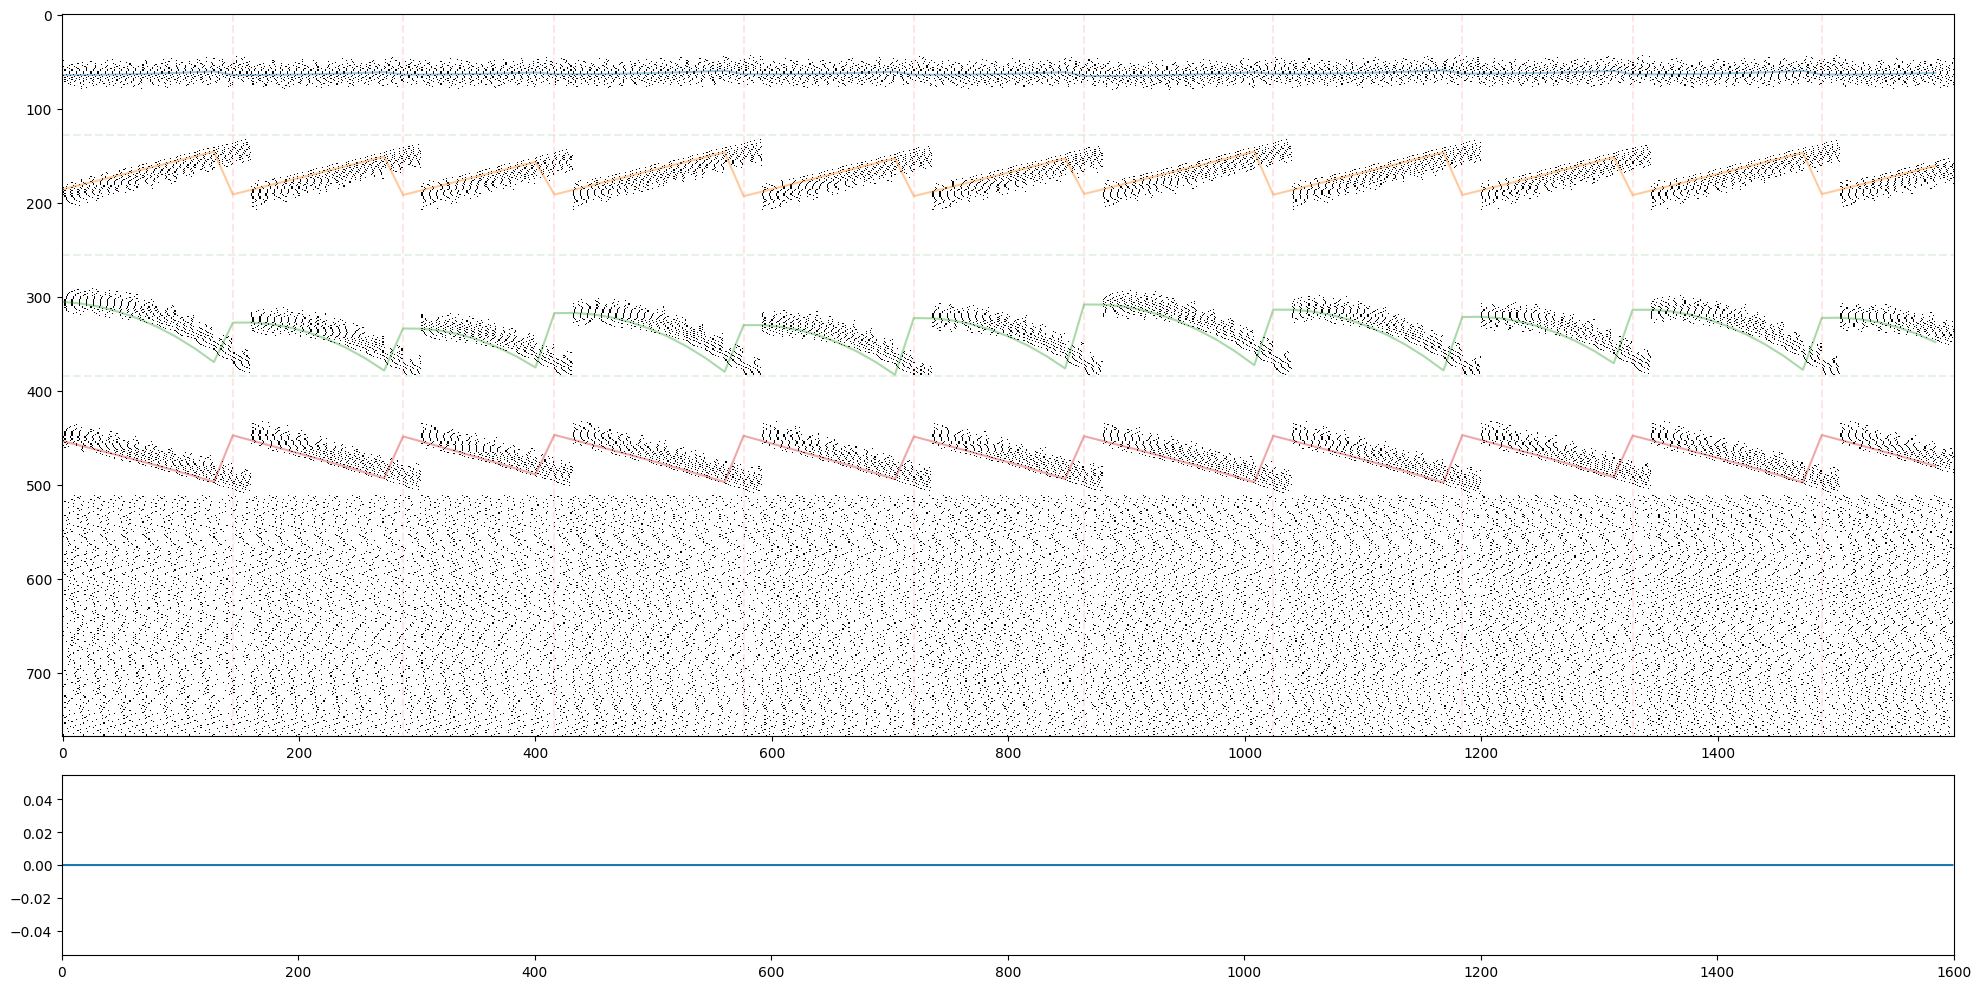

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,spikes.shape[1]-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[0]+64, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[1]+64+128, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[2]+64+256, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(actions)
ax[1].set_xlim(0, len(actions))
plt.tight_layout()
plt.show()

<style>
	div.tutorial-text {
		text-align: justify;
		width: 100ch !important;
		font-size: 18px;
	}
</style>

<div class="tutorial-text">

Finally, let's repeat this final run assuming that you had constructed a significanlty more complex model through the graph editor, just for the sake of comparison.

Immediately, we can see that the burden of setting all those maps is replaced by a simple call to a <b>from_file</b> method. However, it is also possible to setup the configuration entirely via code and construct a export it to a file for later reuse via <b>to_file</b>; whatever floats your boat!.
</div>

In [44]:
# Initialize the configuration class
brain_config = spark.nn.BrainConfig.from_file('./example_model.scfg')
# Construct the brain.
brain = spark.nn.Brain(config=brain_config)
# Build the brain.
brain(drive=spark.FloatArray(jnp.zeros((4,), dtype=jnp.float16)))

{'integrator.signal': FloatArray(value=Array([0., 0.], dtype=float16))}

In [45]:
next_obs, _ = env.reset(seed=42)
next_obs = process_obs(next_obs)

graph, state = spark.split((model))

reward = 0
reward_array = []
for i in tqdm(range(10000)):
	prev_obs = next_obs
	# Model logic
	out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
	# Environment logic.
	next_action = int(np.argmax(out['integrator.signal'].value))
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		next_obs, _ = env.reset()
		# Flush model
		for i in range(16):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	reward_array.append(reward)

100%|██████████| 10000/10000 [00:18<00:00, 527.29it/s]


In [46]:
outs = []
spikes = []
obs = []
breaks = []
break_obs = []
actions = []
reward = 0
next_obs, _ = env.reset(seed=42+1)
next_obs = process_obs(next_obs)
for i in tqdm(range(100)):
	prev_obs = next_obs
	# Model logic
	for _ in range(brain_steps_per_env_step):
		out, state = run_model(graph, state, spark.FloatArray(jnp.array(next_obs, dtype=jnp.float16)))
		outs.append(out['integrator.signal'].value)
		model_spikes = retrieve_spikes(graph, state)
		spikes.append(
			jnp.concatenate([
				model_spikes['spiker'].value.reshape(-1),
				model_spikes['A_ex'].value.reshape(-1),
				model_spikes['A_in'].value.reshape(-1),
				model_spikes['B_ex'].value.reshape(-1),
				model_spikes['B_in'].value.reshape(-1),
			])
		)
		# Environment logic.
		next_action = int(np.argmax(out['integrator.signal'].value))
		actions.append(next_action)
	next_obs, _, terminated, truncated, info = env.step(next_action)
	if terminated:
		break_obs.append(next_obs)
		next_obs, _ = env.reset()
		breaks.append(brain_steps_per_env_step*i)
		# Flush model
		for i in range(50):
			_, state = run_model(graph, state, spark.FloatArray(jnp.zeros_like(next_obs, dtype=jnp.float16)))
	next_obs = process_obs(next_obs)
	reward = compute_real_reward(next_obs, prev_obs, reward, terminated)
	obs.append(next_obs)
model = spark.merge(graph, state)
spikes = np.abs(np.array(spikes))



100%|██████████| 100/100 [00:01<00:00, 58.41it/s]


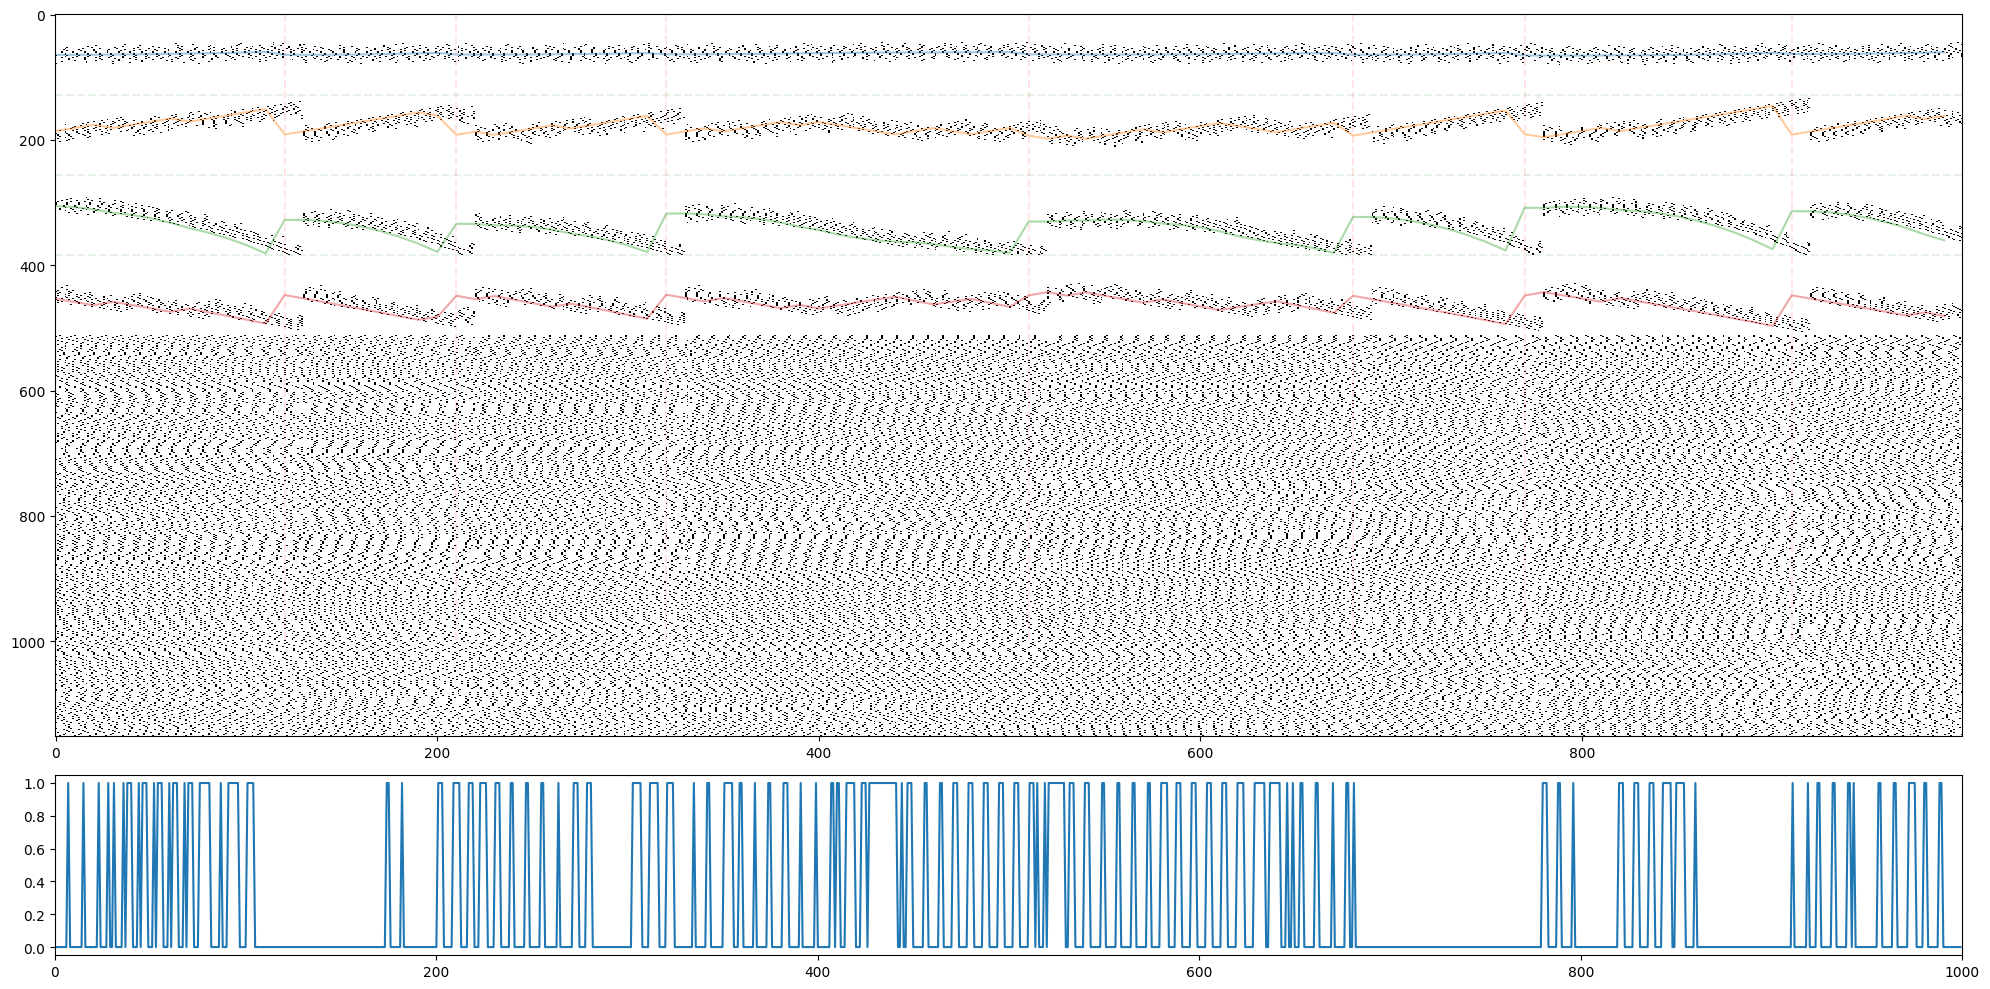

In [47]:
fig, ax = plt.subplots(2,1,figsize=(20,10), height_ratios=(8,2))
ax[0].imshow(1-spikes.T, cmap='gray', aspect='auto', interpolation='none')
for b in breaks:
    ax[0].plot([b,b], [0-0.5,len(spikes)-0.5], 'r--', alpha=0.1)
for i in range(3):
    ax[0].plot([0-0.5,len(spikes)-0.5], [128*(i+1), 128*(i+1)], 'g--', alpha=0.1)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[0]+64, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[1]+64+128, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[2]+64+256, alpha=0.4)
ax[0].plot(brain_steps_per_env_step*np.arange(len(spikes)//brain_steps_per_env_step), 64*np.array(obs).T[3]+64+128+256, alpha=0.4)
ax[1].plot(actions)
ax[1].set_xlim(0, len(actions))
plt.tight_layout()
plt.show()